# Analysis of Bathymetric Data
This script was adapted from previously written code for use in Smart Coasts.

In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.signal import butter,filtfilt

Imported Plotly, but it will not work without significant reconfiguration. Converting to Cartopy for static maps for now.

In [17]:
import plotly
import plotly.graph_objs as go

#Use the line below to check os environment...
#print(os.environ)

### Read in Data, Rename Columns, Simple Data Pre-processing

In [27]:
#Define filename to read data into Jupyter notebook

#filename = '00000009raw2shortened'

filename = '24031201_depth-sensing-ping_Seahawkanddock_truncate'

fullname = filename +'.csv'

#filepath = os.path.join('C:\\Users\crsul\OneDrive - UNC-Wilmington\Classes\Smart Coasts (GEO 592)', fullname)

filepath = os.path.join('C:\\Users\crsul\Downloads', fullname)

#"C:\Users\crsul\OneDrive - UNC-Wilmington\Classes\Smart Coasts (GEO 592)\24110400.csv"

#Check that the filepath is correct
print(filepath)

df = pd.read_csv(filepath, parse_dates = [[0, 1]], header = None)
                 
df.columns = ['time','elapsed time (sec)', 'lat_raw', 'N or S', 'lon_raw', 'E or W', 'temp (oC)', 'depth (cm)', 'altitude', 'speed', 'angle']

#Check the data
print(df)

df.head()

C:\Users\crsul\Downloads\24031201_depth-sensing-ping_Seahawkanddock_truncate.csv
                   time  elapsed time (sec)    lat_raw N or S    lon_raw  \
0   2024-03-12 21:12:30                  92  3408.4041      N  7751.7363   
1   2024-03-12 21:12:31                  93  3408.4041      N  7751.7363   
2   2024-03-12 21:12:32                  94  3408.4041      N  7751.7363   
3   2024-03-12 21:12:33                  95  3408.4038      N  7751.7363   
4   2024-03-12 21:12:34                  96  3408.4041      N  7751.7363   
..                  ...                 ...        ...    ...        ...   
299 2024-03-12 21:17:31                 393  3408.4082      N  7751.7349   
300 2024-03-12 21:17:32                 394  3408.4082      N  7751.7349   
301 2024-03-12 21:17:33                 395  3408.4082      N  7751.7349   
302 2024-03-12 21:17:34                 396  3408.4082      N  7751.7349   
303 2024-03-12 21:17:35                 397  3408.4082      N  7751.7349   

    E 

,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,temp (oC),depth (cm),altitude,speed,angle
0,2024-03-12 21:12:30,92,3408.4041,N,7751.7363,W,0.68,665.24,-1.6,0.14,119.76
1,2024-03-12 21:12:31,93,3408.4041,N,7751.7363,W,0.52,220.64,-1.6,0.14,119.76
2,2024-03-12 21:12:32,94,3408.4041,N,7751.7363,W,1.08,160.52,-1.6,0.69,162.13
3,2024-03-12 21:12:33,95,3408.4038,N,7751.7363,W,2.37,23.09,-1.6,1.03,42.43
4,2024-03-12 21:12:34,96,3408.4041,N,7751.7363,W,0.27,22.79,-1.5,1.02,53.83


In [28]:
# df = df[100:-30] # TODO: replace with a filter for altitude or motion

# GPS prints out lat DDMM.MMMM, lon DDDMM.MMMM, so additional processing required
def lat_convert(lat_badfmt):
    lat_badfmt = str(lat_badfmt)
    lat_DD = int(float(lat_badfmt)/100) # get DDD part
    lat_MM = float(lat_badfmt)-lat_DD*100 # get MM.MMM part
    lat_deg = float(lat_DD)+float(lat_MM)/60 # add minutes divided by 60 to degrees
    return lat_deg

def lon_convert(lon_badfmt):
    lon_badfmt = str(lon_badfmt)
    lon_DD = int(float(lon_badfmt)/100) # get DDD part
    lon_MM = float(lon_badfmt)-lon_DD*100 # get MM.MMM part
    lon_deg = float(lon_DD)+float(lon_MM)/60 # add minutes divided by 60 to degrees
    return lon_deg

# Do the conversion on real data
df['lat'] = df['lat_raw'].apply(lat_convert)
df['lon'] = df['lon_raw'].apply(lon_convert)

# South should be negative
south = df['N or S'] == 'S'
df['lat'][south] *= -1 

# West should be negative
west = df['E or W'] == 'W'
df['lon'][west] *= -1 

# Take a look
df.head()

C:\Users\crsul\AppData\Local\Temp\ipykernel_19964\564657591.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'][south] *= -1
C:\Users\crsul\AppData\Local\Temp\ipykernel_19964\564657591.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon'][west] *= -1


,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,temp (oC),depth (cm),altitude,speed,angle,lat,lon
0,2024-03-12 21:12:30,92,3408.4041,N,7751.7363,W,0.68,665.24,-1.6,0.14,119.76,34.140068,-77.862272
1,2024-03-12 21:12:31,93,3408.4041,N,7751.7363,W,0.52,220.64,-1.6,0.14,119.76,34.140068,-77.862272
2,2024-03-12 21:12:32,94,3408.4041,N,7751.7363,W,1.08,160.52,-1.6,0.69,162.13,34.140068,-77.862272
3,2024-03-12 21:12:33,95,3408.4038,N,7751.7363,W,2.37,23.09,-1.6,1.03,42.43,34.140063,-77.862272
4,2024-03-12 21:12:34,96,3408.4041,N,7751.7363,W,0.27,22.79,-1.5,1.02,53.83,34.140068,-77.862272


### Scale from c_air to c_water
Firmware currently calculates distance using speed of sound in air. We want speed of sound in water.

In [29]:
# Convert depth in air to depth in water
df['depth (cm)'] = df['depth (cm)']*1502/343

#Check the data
print(df)

display(df)

                   time  elapsed time (sec)    lat_raw N or S    lon_raw  \
0   2024-03-12 21:12:30                  92  3408.4041      N  7751.7363   
1   2024-03-12 21:12:31                  93  3408.4041      N  7751.7363   
2   2024-03-12 21:12:32                  94  3408.4041      N  7751.7363   
3   2024-03-12 21:12:33                  95  3408.4038      N  7751.7363   
4   2024-03-12 21:12:34                  96  3408.4041      N  7751.7363   
..                  ...                 ...        ...    ...        ...   
299 2024-03-12 21:17:31                 393  3408.4082      N  7751.7349   
300 2024-03-12 21:17:32                 394  3408.4082      N  7751.7349   
301 2024-03-12 21:17:33                 395  3408.4082      N  7751.7349   
302 2024-03-12 21:17:34                 396  3408.4082      N  7751.7349   
303 2024-03-12 21:17:35                 397  3408.4082      N  7751.7349   

    E or W  temp (oC)   depth (cm)  altitude  speed   angle        lat  \
0        W   

,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,temp (oC),depth (cm),altitude,speed,angle,lat,lon
0,2024-03-12 21:12:30,92,3408.4041,N,7751.7363,W,0.68,2913.091778,-1.6,0.14,119.76,34.140068,-77.862272
1,2024-03-12 21:12:31,93,3408.4041,N,7751.7363,W,0.52,966.184490,-1.6,0.14,119.76,34.140068,-77.862272
2,2024-03-12 21:12:32,94,3408.4041,N,7751.7363,W,1.08,702.918484,-1.6,0.69,162.13,34.140068,-77.862272
3,2024-03-12 21:12:33,95,3408.4038,N,7751.7363,W,2.37,101.111312,-1.6,1.03,42.43,34.140063,-77.862272
4,2024-03-12 21:12:34,96,3408.4041,N,7751.7363,W,0.27,99.797609,-1.5,1.02,53.83,34.140068,-77.862272
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,2024-03-12 21:17:31,393,3408.4082,N,7751.7349,W,3.42,101.417843,2.5,0.41,165.16,34.140137,-77.862248
300,2024-03-12 21:17:32,394,3408.4082,N,7751.7349,W,1.40,107.285714,2.5,0.28,165.16,34.140137,-77.862248
301,2024-03-12 21:17:33,395,3408.4082,N,7751.7349,W,2.37,102.074694,2.5,0.15,165.16,34.140137,-77.862248
302,2024-03-12 21:17:34,396,3408.4082,N,7751.7349,W,1.00,100.235510,2.5,0.12,165.16,34.140137,-77.862248


### Plot Unedited Time-series

In [1]:
#Plot unaltered data
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df['time'], df['depth (cm)'], '.')

axs.set_ylabel('Depth (cm)')
axs.set_xlabel('Time')

axs.invert_yaxis()

fig.autofmt_xdate()

NameError: name 'plt' is not defined

### Noise Reduction

In [35]:
# Filter requirements, 
# example from https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

T = 1.0         # Sample Period, sec
fs = 150.0       # sample rate, Hz
cutoff = 1.5    # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

### Filter Definition

In [36]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [37]:
# Filter the data, and plot both the original and filtered signals
depth_above_range = 600
depth_below_range = 23
df = df[df['depth (cm)']<depth_above_range]
df = df[df['depth (cm)']>depth_below_range]

data = df['depth (cm)']
depth_filt = butter_lowpass_filter(data, cutoff, fs, order)
df['depth filt (cm)'] = depth_filt

# Check filtered data
print(depth_filt)

[101.33182789 101.36244131 101.39415231 101.42701084 101.46103691
 101.49621799 101.53252135 101.56991282 101.6083604  101.64781966
 101.68822308 101.72948099 101.77148279 101.81409625 101.8571679
 101.90052758 101.94400564 101.98746087 102.03078807 102.07389479
 102.11669037 102.15910524 102.20110082 102.24265157 102.28373125
 102.32431717 102.36439105 102.403934   102.44292427 102.48134283
 102.5191849  102.5564591  102.59317378 102.62933067 102.66492713
 102.69995018 102.73437247 102.76818225 102.80142184 102.83418756
 102.86661477 102.89887584 102.93118161 102.96377952 102.99694094
 103.03093888 103.0660309  103.10245381 103.14042094 103.18011641
 103.22169141 103.26526508 103.31092689 103.35873435 103.40870253
 103.46079667 103.51493697 103.57101507 103.62891743 103.68853578
 103.74975959 103.81247566 103.87657553 103.94195168 104.00848924
 104.07606329 104.14453701 104.21376127 104.28357147 104.35377576
 104.42415439 104.49448402 104.56455548 104.63415955 104.70306722
 104.771025

### Plot Filtered Time-series and Original Time-series

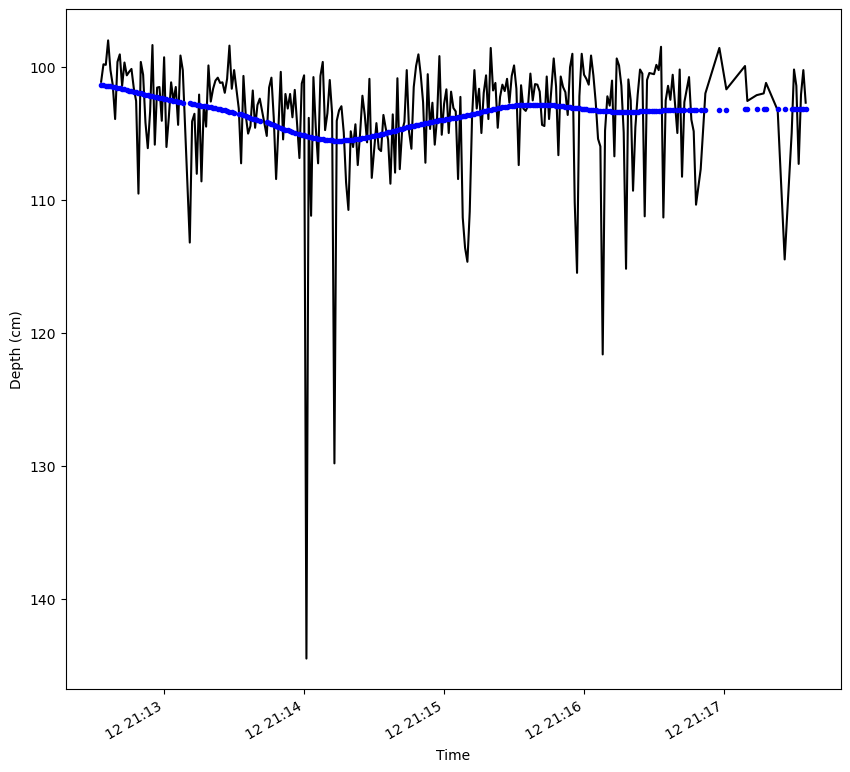

In [38]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df['time'], df['depth (cm)'], '-k')
axs.plot(df['time'], df['depth filt (cm)'], '.b')

axs.set_ylabel('Depth (cm)')
axs.set_xlabel('Time')

axs.invert_yaxis()

fig.autofmt_xdate()

### Plot Latitude to See Movement

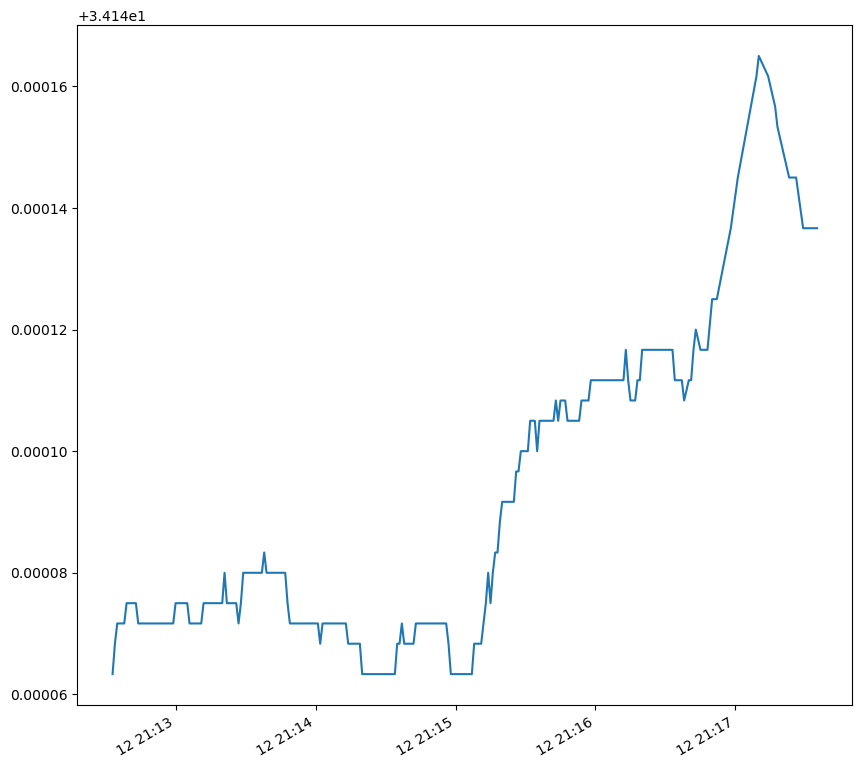

In [26]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df['time'], df['lat'])
fig.autofmt_xdate()

### Plot Spatial Data (redone using map overlays below)

In [ ]:
fig, axs = plt.subplots(figsize = (10, 10))
m = axs.scatter(df['lon'], df['lat'], c = df['depth filt (cm)'])
fig.colorbar(m)

# Map of variable of interest

### Put on cartopy to get good basemap
- Image tile options via Cartopy are currently buried in the API under cartopy.io.img_tiles described here: https://scitools.org.uk/cartopy/docs/latest/_modules/cartopy/io/img_tiles.html. Scroll down to see different options under the different classes. Change the class 
- Here are some examples of the Mapbox style offerings: https://docs.mapbox.com/api/maps/styles/. Change `map_id` to use others.
- See also https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html for formatting.

### Options
See below for several examples. Then in subsequent cell, define which choice you'd like by setting `base_layer` and `tile_zoom` to match one of these examples.

In [ ]:
# Map options: (un)comment blocks corresponding to choice and check to make sure base_layer and tile_zoom are defined

## Stamen (apparently discontinued...)
#base_layer_stamen = cimgt.Stamen('terrain')
#tile_zoom_stamen = 12

## Mapbox
#Copied and pasted a public token to access the Mapbox website and maps
map_id = 'satellite-streets-v11'
base_layer_mapbox = cimgt.MapboxTiles('pk.eyJ1IjoiY3JzODk3MyIsImEiOiJjbTQ0dmxvbnYwcnpvMmpvaGdmeXQ3M3lqIn0.OVQA-i7OpmhYcZAkSkcwMg', map_id=map_id)
tile_zoom_mapbox = 20

## Open Street Maps
base_layer_OSM = cimgt.OSM()
tile_zoom_OSM = 1

In [ ]:
## DEFINE BASE_LAYER AND TILE_ZOOM HERE!
base_layer = base_layer_mapbox
tile_zoom = tile_zoom_mapbox

# Get desired variable
var_name = 'depth (cm)' # selected from columns above
plot_var = df[var_name]
lat = df['lat']
lon = df['lon']

plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16

In [ ]:
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot limits
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac

fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=base_layer.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=crs)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)
cb.ax.invert_yaxis()

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}

figname = filename + var_name+'.png'
figpath = os.path.join('Figs', figname)

# plt.savefig(figpath, dpi = 300) # (un)comment depending on preference for saving figure locally

In [ ]:
# Get data statistics
df.describe()